In [51]:
import psycopg2, multiprocessing, psycopg2.extras, os, json, sys, time, scipy, datetime
from multiprocessing import Pool, Manager 
from collections import Counter
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Temporal Clustering

In [52]:
input_directory  = "/data/chime/geo2/PROCESSED/FL/martin_palm_beach_counties_Stage1/"
output_directory = "/data/chime/geo2/PROCESSED/FL/martin_palm_beach_counties_Stage2"

#SANDY
# _landfall_str = '201210300000' # Remember, this is UTC
# _start_str    = '201210290000' # (ie when was the evacuation ordered (8pm the 28th)
# _end_str      = '201210310000'
# _landfall = pd.Timestamp(_landfall_str)
# _start    = pd.Timestamp(_start_str)
# _end      = pd.Timestamp(_end_str)

#MATTHEW
_landfall_str = '201610060000' #Using these dates for Matthew...
_start_str    = '201610040000' # (ie when was the evacuation?)
_end_str      = '201610080000'
_landfall = pd.Timestamp(_landfall_str)
_start    = pd.Timestamp(_start_str)
_end      = pd.Timestamp(_end_str)

## 0. Load all the geo-clustered tweets

In [53]:
users_in = sorted(os.listdir(input_directory))
print("Found {0} users in {1}".format(len(users_in), input_directory))

Found 984 users in /data/chime/geo2/PROCESSED/FL/martin_palm_beach_counties_Stage1/


## Sampling?!

<hr>

In [54]:
def loader_function(args):
    uFile, path, q = args
    u = json.load(open(path+"/"+uFile,'r'))
    tweets = []
    for t in u['features']:
        if t['geometry']:
            t['properties']['geometry'] = shape(t['geometry'])
        t['properties']['date'] = pd.Timestamp(t['properties']['date'])
        tweets.append(t['properties'])
    q.put(1)
    return gpd.GeoDataFrame(tweets)

In [55]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, input_directory, q) for i in users_in]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))
users = result.get()
p.close()

Processed: 984, 100%%

In [56]:
print("{0} total tweets for all users".format(sum([len(x) for x in users])))

83543 total tweets for all users


In [57]:
user_names_in = [x[:-8] for x in users_in]
user_names_in[:5]

['11zette17', '1728_johnsona', '1avination', '1jazzyjeff', '1kingeazzy']

## Identifying Temporal Clusters
Use a custom _worker_ function to find specific time clusters

### Enough Tweets?

Ensure that we have the following for each user:
1. Geo-Cluter Information (If no geo-clusters are available, remove)
2. Enough Tweets (At least *A* Tweet during the storm)

In [58]:
def time_cluster(t):
    '''Given a time, returns the cluster (1 of 12)'''
    t = t.tz_convert("EST")
    hour = t.hour//4 + 1
    if t.weekday()>4:
        return 6+hour
    else:
        return hour
    
def worker_function(args):
    userDF, q = args
    
    #If no tweets around the time of the storm, then fail. 
    #TODO: Move this up in the processing chain to improve performance
    if len(userDF.query("date > %s & date < %s"%(_start_str, _end_str))) < 1:
        q.put(1)
        return None
    
    userDF['day_cluster'] = userDF.date.apply(lambda t: time_cluster(t))
    q.put(0)
    return userDF

In [59]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in users]
result = p.map_async(worker_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))

values = result.get()
x = [i for i in values  if i is not None]
nones = [i for i in values  if i is None]
p.close()

Processed: 984, 100%%

In [60]:
print("Successfully processed {0} users\n{1} Users failed".format(len(x),len(nones)))
users_past_first_step = [x.user[0].lower() for x in values if x is not None]
print("First 5 users past the first step", users_past_first_step[:5])

Successfully processed 496 users
488 Users failed
First 5 users past the first step ['1728_johnsona', '1avination', '1jazzyjeff', '1kingeazzy', '2kbluevette']


In [61]:
#Failed:
failed_users = set(user_names_in) - set(users_past_first_step)
print("Failed user set size: ", len(failed_users))

Failed user set size:  488


In [62]:
_users = sorted(x, key=lambda y: len(y), reverse=True) # Put the verbose users up front

## 2. Group the clusters and find which geo-clusters correspond with home hours

In [63]:
def rank_clusters(df):
    """
    There is definitely room for the logic in _this_ function to improve, but for now it looks good :) 
    """
    gb_geo = df.query('date < '+_start_str).groupby('cluster')
    if len(gb_geo) < 1:
        return (None,None)
    _agged = gb_geo['day_cluster'].agg({"tweets":pd.Series.count,
                                        "Number Unique Times":pd.Series.nunique,
                                        "day_cluster_counts": lambda t: Counter(t),
                                        "HomeTimes": lambda t: any(t==1) or any(t==2) or any(t==6),
                                      }).sort_values('Number Unique Times', ascending=False).query('cluster>0')
    hc = None
    
    #If there is a cluster with hometimes, then return that (highest rated based on unique times)
    if len(_agged.query('HomeTimes'))>0:
        hc = _agged.query('HomeTimes').iloc[0].name
        
    return hc, _agged

In [64]:
vals= []
len_users = len(_users)
user_collection = []

user_meta_collection = []
for idx, U in enumerate(_users):
    
    hc = rank_clusters(U)[0]
    if hc is None:
        hc_coords = None
    else:
        hc_coords = U.query("cluster=={0}".format(hc))['cluster_center'].values[0]
        
    user_meta_collection.append({
            'user':U['user'].values[0],
            'uid' :U['uid'].values[0],
            'tweets':len(U),
            'home_cluster': hc,
            'home_cluster_coords':hc_coords
        })

    U['home_cluster_id'] = pd.Series(hc)
    
    sys.stderr.write("\r{0} of {1}".format(idx+1, len_users))
_user_meta = pd.DataFrame(user_meta_collection)
sys.stderr.write("\n\nClustered: {0}, Failed: {1}".format( len(_user_meta[~np.isnan(_user_meta.home_cluster)]),
                                                           len(_user_meta[ np.isnan(_user_meta.home_cluster)])))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
496 of 496

Clustered: 363, Failed: 133

In [65]:
users_with_homes = [u for u in _users if u.home_cluster_id.count()>0]

Identify which users do not make it past?

In [66]:
users_past_second_step = [x.user[0].lower() for x in users_with_homes]

In [67]:
pitched_users = set(users_past_first_step) - set(users_past_second_step)
print("This many users from first step did not make it past the second step: ", len(pitched_users))

This many users from first step did not make it past the second step:  133


### Export these results

In [68]:
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [69]:
#Export the User Meta Dataframe first
with open(output_directory+'/'+'temporal_clustered_user_meta.json','w') as metaOut:
    metaOut.write(_user_meta.to_json())

In [70]:
_user_meta.head()

,home_cluster,home_cluster_coords,tweets,uid,user
0,11.0,"{""coordinates"": [-80.20819619047614, 25.861914...",10784,249831776,TotalTrafficMIA
1,134.0,"{""coordinates"": [-78.01829999999997, 33.914999...",3523,4754740136,ebbtidebot
2,1.0,"{""coordinates"": [-80.0692510000025, 26.3507769...",3213,174303316,ClickWhisperer
3,7.0,"{""coordinates"": [-80.19179020000009, 25.761679...",1786,563319506,CVSHealthJobs
4,51.0,"{""coordinates"": [-77.36635380000003, 35.612661...",1691,3144822634,SpeedwayJobs


## 3.  Write these users to disk

In [71]:
def safe_mapping(p):
    if p==None or np.isnan(p).any():
        return None
    else:
        return mapping(p)

In [72]:
def safe_json_export(args):
    df, path, q = args
    df = df.copy()
    uName = df.head(1).user.values[0].lower()
    df['date'] = df['date'].apply(lambda t: datetime.datetime.strftime(t,'%Y-%m-%dT%H:%M:%SZ'))

    #Write the metadata:
    with open('/data/www/chime/movement-derivation/user-metadata/'+uName+".geojson",'w') as userMeta:
        userMeta.write(df.query("cluster=={0}".format(df.iloc[0].home_cluster_id)).cluster_center.values[0])

    clean = df.where((pd.notnull(df)), None)
    geojson = {"type":"FeatureCollection","features":[]}
    for _, row in clean.iterrows():
        geom = safe_mapping(row.geometry)
        feature = {'type':'Feature',
                   'geometry':geom,
                   'properties':row.to_dict()
                    }
        del feature['properties']['geometry']
        geojson['features'].append(feature)
    
    with open(path+"/"+uName+'.geojson','w') as oFile:
        json.dump(geojson, oFile) 

    if q is not None:
        q.put(1)

In [73]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, output_directory, q) for i in users_with_homes]
result = p.map_async(safe_json_export, args)

sys.stderr.write("Exporting {0} users to {1}\n".format(len(args),output_directory))

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
p.close()
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))

Exporting 363 users to /data/chime/geo2/PROCESSED/FL/martin_palm_beach_counties_Stage2
Processed: 363, 100%%

<hr>
<hr>
# End of Processing 

<hr><hr>
# Beginning of Visual Inspection

In [24]:
x = users_with_homes[0]

In [25]:
x.cluster.count()

3523

In [26]:
cluster_dist = pd.Series(sorted([u.cluster.nunique() for u in _users]))

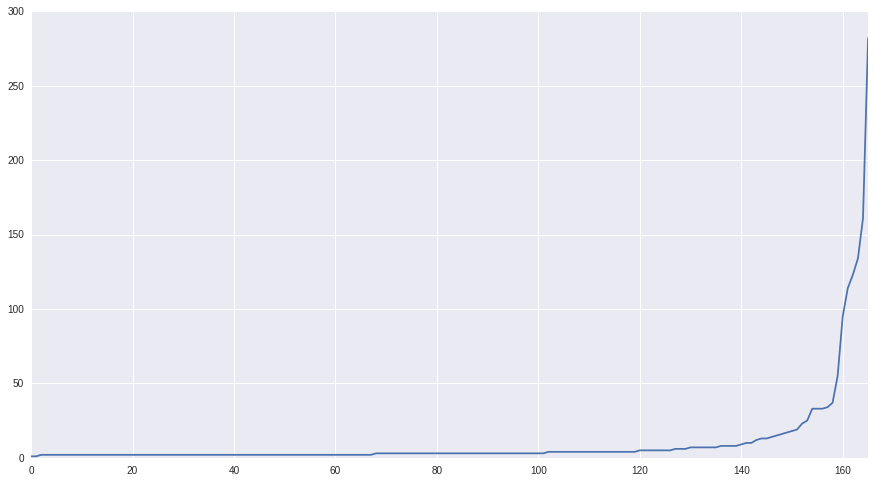

In [27]:
cluster_dist.plot(figsize=(15,8))

In [28]:
x.head()

,cluster,cluster_center,coords,date,geo_delta,geometry,speed,text,time_delta,tweet_id,uid,user,day_cluster,home_cluster_id
0,1,"{""type"": ""Point"", ""coordinates"": [-76.6717, 34...","[-76.6717, 34.7683]",2016-08-01 01:10:00+00:00,NaN,POINT (-76.6717 34.7683),NaN,"@ebbtideapp Tide in Newport River, North Carol...",NaN,759919075011072000,4754740136,ebbtidebot,12,134.0
1,2,"{""type"": ""Point"", ""coordinates"": [-81.15, 31.6...","[-81.15, 31.7]",2016-08-01 01:20:00+00:00,538300.686971,POINT (-81.15000000000001 31.7),897.167812,"@ebbtideapp Tide in Walburg Creek entrance, Ge...",600.0,759921589932560385,4754740136,ebbtidebot,12,NaN
2,3,"{""type"": ""Point"", ""coordinates"": [-79.27499999...","[-79.275, 33.195]",2016-08-01 01:25:00+00:00,242044.074103,POINT (-79.27500000000001 33.195),806.813580,"@ebbtideapp Tide in Minim Creek ent., South Ca...",300.0,759922848995561476,4754740136,ebbtidebot,12,NaN
3,4,"{""type"": ""Point"", ""coordinates"": [-79.7067, 32...","[-79.7067, 32.8567]",2016-08-01 02:15:00+00:00,55089.447252,POINT (-79.7067 32.8567),18.363149,"@ebbtideapp Tide in Capers Creek, South Caroli...",3000.0,759935433241354240,4754740136,ebbtidebot,12,NaN
4,5,"{""type"": ""Point"", ""coordinates"": [-77.09999999...","[-77.1, 34.65]",2016-08-01 02:40:00+00:00,312772.132849,POINT (-77.09999999999999 34.65),208.514755,"@ebbtideapp Tide in Bogue Inlet, North Carolin...",1500.0,759941723912933376,4754740136,ebbtidebot,12,NaN
